In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

from Generator import Generator
import matplotlib.pyplot as plt

## Parameters

#### Data Generation

In [2]:
low = 1                                    #
high = 100                                     #
rank = False                                  #
normalize = True

train_examples = 10000
test_examples = 100

#### Model

In [3]:
embed_dim = 2048                            #
stack = 6                                    #

optimizer = keras.optimizers.Nadam()         #
loss = keras.losses.MSE                      # Regression Loss Function


metrics = keras.metrics.MeanSquaredError()

2022-04-21 18:09:01.866383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-21 18:09:01.895855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-21 18:09:01.896511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-21 18:09:01.898096: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

#### Training

In [4]:
batch_size = 48
epochs = 1000

validation_split = 0.2
verbose = 2

## Generate Data

In [5]:
generator = Generator('nutrients.csv') # filename with data

In [6]:
generator.generate(train_examples) # generates arg number of examples
generator.scale(low,high) # scales ingredients individually between min and max arg values
if rank:
    generator.rank()
    
if normalize:
    generator.normalize()

In [7]:
generator.recipes.shape

(10000, 15, 13)

## Build Model

In [8]:
embed_dim = embed_dim
stack = stack
i1 = keras.layers.Input(generator.recipes.shape[1:])
f1 = keras.layers.Flatten()(i1)
y1 = keras.layers.Dense(embed_dim)(f1)

# Stack residual blocks (skip connections)
for _ in range(stack):
    y2 = y1
    y1 = keras.layers.Dense(embed_dim,
        activation=keras.activations.relu)(y1)
    y1 = keras.layers.Add()([y1,y2])
    y1 = keras.layers.LayerNormalization()(y1)

if normalize:
    o1 = keras.layers.Dense(generator.recipes.shape[1],activation=keras.activations.softplus)(y1)
    
else:
    o1 = keras.layers.Dense(generator.recipes.shape[1])(y1)
    
model = keras.Model(i1,o1)

In [9]:
#keras.utils.plot_model(model,to_file='recipe_model.png',show_shapes=True,expand_nested=True)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 13)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 195)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 2048)         401408      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2048)         4196352     ['dense[0][0]']                  
                                                                                              

In [11]:
model.compile(optimizer=optimizer,
            loss=loss,
            metrics=metrics)

In [12]:
filepath = f"{normalize}_{embed_dim}_{stack}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_freq=250)
callbacks_list = [checkpoint]

## Train

In [13]:
history = model.fit(
    generator.recipes, generator.quant, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split = validation_split, 
    verbose=verbose,
    callbacks = callbacks_list
)

Epoch 1/1000


2022-04-21 18:09:07.743626: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-04-21 18:09:07.978758: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


167/167 - 10s - loss: 0.2321 - mean_squared_error: 0.2321 - val_loss: 0.2178 - val_mean_squared_error: 0.2178 - 10s/epoch - 60ms/step
Epoch 2/1000

Epoch 00002: loss improved from inf to 0.22512, saving model to True_2048_6.h5


/home/chandler/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


167/167 - 7s - loss: 0.2202 - mean_squared_error: 0.2202 - val_loss: 0.2128 - val_mean_squared_error: 0.2128 - 7s/epoch - 40ms/step
Epoch 3/1000

Epoch 00003: loss did not improve from 0.22512
167/167 - 6s - loss: 0.3388 - mean_squared_error: 0.3388 - val_loss: 0.1935 - val_mean_squared_error: 0.1935 - 6s/epoch - 38ms/step
Epoch 4/1000
167/167 - 6s - loss: 0.1950 - mean_squared_error: 0.1950 - val_loss: 0.2116 - val_mean_squared_error: 0.2116 - 6s/epoch - 38ms/step
Epoch 5/1000

Epoch 00005: loss improved from 0.22512 to 0.20122, saving model to True_2048_6.h5
167/167 - 7s - loss: 0.1999 - mean_squared_error: 0.1999 - val_loss: 0.1984 - val_mean_squared_error: 0.1984 - 7s/epoch - 41ms/step
Epoch 6/1000

Epoch 00006: loss did not improve from 0.20122
167/167 - 6s - loss: 0.2030 - mean_squared_error: 0.2030 - val_loss: 0.2002 - val_mean_squared_error: 0.2002 - 6s/epoch - 39ms/step
Epoch 7/1000
167/167 - 7s - loss: 0.2198 - mean_squared_error: 0.2198 - val_loss: 0.2134 - val_mean_squared_

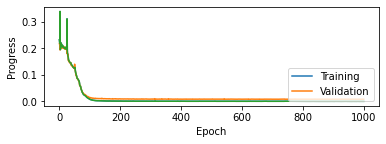

In [14]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['loss'])
plt.ylabel('Progress')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')

## Testing Fake Data

In [15]:
#prediction values
test_gen = Generator('nutrients.csv')
test_gen.generate(test_examples) # generates arg number of examples
test_gen.scale(low,high) # scales ingredients individually between min and max arg values

if rank:
    test_gen.rank()
    
if normalize:
    test_gen.normalize()

In [16]:
test_recipes = test_gen.recipes
test_quant = test_gen.quant

In [17]:
score = model.evaluate(test_recipes, test_quant, verbose=1)

4/4 [==============================] - 0s 10ms/step - loss: 0.0084 - mean_squared_error: 0.0084


In [18]:
pred = model.predict(test_recipes)
if normalize:
    pred = test_gen.inv_normalize(pred)

In [19]:
actual = test_gen.quant
if normalize:
    actual = test_gen.inv_normalize(actual)

In [20]:
index = 0

In [21]:
for i in range(len(pred[0])):
    pred_num = str(round(pred[index,i],3))
    act_num = str(round(actual[index,i],3))
    
    print(f"pred: {pred_num} | actual: {act_num}" )

pred: 7.265 | actual: 12.068
pred: 7.693 | actual: 8.732
pred: 0.076 | actual: 0.0
pred: 24.299 | actual: 22.374
pred: 82.374 | actual: 83.16
pred: 83.296 | actual: 85.378
pred: 37.679 | actual: 37.986
pred: 0.042 | actual: 0.0
pred: 2.2 | actual: 1.624
pred: 0.119 | actual: 0.0
pred: 41.4 | actual: 38.659
pred: 0.987 | actual: 0.0
pred: 21.923 | actual: 18.295
pred: 81.235 | actual: 87.952
pred: 15.043 | actual: 16.266


## Testing Real Data

In [1]:
recipe_quant = "./Recipe Data.csv"
ingr_nutr = "./nutrients.csv"

In [2]:
from RealData import RealData

ImportError: cannot import name 'RealData' from 'RealData' (/home/chandler/s22-team8-project/RealData.py)

In [ ]:
realdata = RealData(recipe_quant,ingr_nutr)

In [ ]:
if normalize:
    realdata.normalize()

In [ ]:
pred = model.predict(realdata.recipes)
if normalize:
    pred = realgen.inv_normalize(pred)

In [ ]:
actual = realdata.quant
if normalize:
    actual = realdata.inv_normalize(actual)

In [ ]:
index = 5
for i in range(len(pred[0])):
    pred_num = str(round(pred[index,i],3))
    act_num = str(round(actual[index,i],3))
    
    print(f"pred: {pred_num} | actual: {act_num}" )